In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

# from google.colab import drive
# drive.mount('/content/drive')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <5D194E58-12ED-3EAC-A0C3-0B8CA40037DE> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Problem 1.1: Basics of Autograd

Derivative of sin at pi/4:  0.7071068286895752


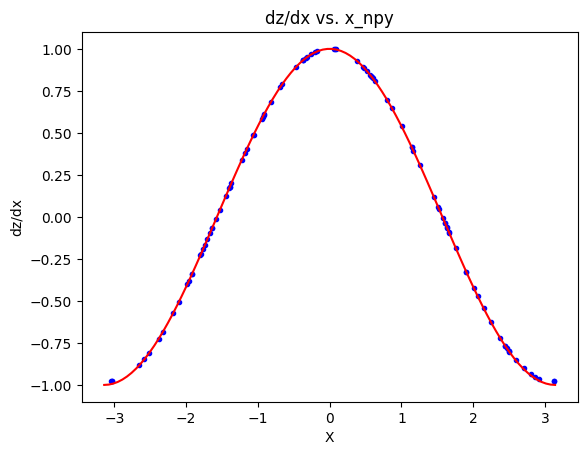

In [ ]:
############################## PART A ##############################


def sin_taylor(x, n=10):
  """
  Taylor approximation to sin(x).
  x: (float) Input value
  n: (int) Number of terms in Taylor approximation
  """
  idx = list(range(1, n+1))[::2]

  est = 0
  for j, i in enumerate(idx):
    est += ((-1)**j) * x**i/math.factorial(i)

  return est


############################## PART B ##############################


x = torch.tensor([math.pi/4])
x.requires_grad_()

y = sin_taylor(x)
y.backward()

print("Derivative of sin at pi/4: ", x.grad.item())


############################## PART C ##############################


x_npy = np.random.uniform(-math.pi, math.pi, 100)
x = torch.from_numpy(x_npy)
x = x.to("cuda")
x.requires_grad_()

y = sin_taylor(x)
y.sum().backward()


############################## PART D ##############################


dz_dx = x.grad.to("cpu").numpy()

plt.plot(x_npy, dz_dx, 'b.')
x_new = np.linspace(-math.pi, math.pi, 100)
plt.plot(x_new, np.cos(x_new), 'r-')
plt.xlabel("X")
plt.ylabel("dz/dx")
plt.title("dz/dx vs. x_npy")

plt.savefig('cos_plot.png', dpi=600)



Problem 1.2: Image Denoising

In [ ]:
"""
Returns the x and y gradient images for input image I.
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (float)
"""
def denoising_loss(I, J, alpha):

  Jx, Jy = get_spatial_gradients(J)

  Jx = torch.flatten(Jx)
  Jy = torch.flatten(Jy)

  diff = torch.flatten(I - J)

  loss = torch.linalg.norm(diff, ord=1) + alpha * (torch.linalg.norm(Jx, ord=1) + torch.linalg.norm(Jy, ord=1))

  return loss

In [ ]:
denoising_loss(I, J, alpha)

tensor(419241.8750, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
img = imageio.v2.imread(r'/content/drive/MyDrive/Colab Notebooks/data/parrot_noisy.png')/255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')
# I.requires_grad_(True)

J = torch.clone(I)
J.requires_grad_(True)

lr = 1 # Learning rate
alpha = 1 # alpha
n_iter = 100 # Number of iterations

for i in range(n_iter):

  loss = denoising_loss(I, J, alpha)

  loss.backward()

  with torch.no_grad():

    J -= lr * torch.nn.functional.normalize(J.grad)

  J.grad.zero_()


J = J.detach().cpu().numpy()



fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img)
ax[1].imshow(J)
ax[0].title.set_text('Original Image')
ax[1].title.set_text('Smoothed Image')
# fig.suptitle(f'Learning rate of: {lr}, Alpha value of: {alpha}')
fig.savefig('parrots_l1.png')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Problem 2: Training an Image Classifier

2a: Finish implementing dataset class

In [3]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      self.images = images[0:40000]
      self.img_labels = labels[0:40000]


    elif mode == 'val':
      self.images = images[40000:50000]
      self.img_labels = labels[40000:50000]

    elif mode == 'test':
      self.images = images[50000:60000]
      self.img_labels = labels[50000:60000]

    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):

    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    # 2. Convert the label to a LongTensor (needs to be of this type because it
    # is an integer value and PyTorch will throw an error otherwise)
    # 3. Transform the image using self.transform. This will convert the image
    # into a tensor, scale it to [0,1], and apply data augmentations.
    # 4. Return the image and label.

    img = self.images[idx]
    label = self.img_labels[idx]

    label = torch.tensor(label).long()

    img = self.transform(img)

    return (img, label)

  def __len__(self):
    return len(self.img_labels)

2b: Write transforms

In [4]:
cifar = np.load(r'CIFAR.npz')
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=5, scale=(0.8, 1.2)),
    T.ColorJitter(brightness=(0.8,1.2), saturation=(0.8,1.2))])
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = T.Compose([T.ToTensor()]) # No augmentations, but should still include ToTensor().
val_dataset = CIFARDataset(X, y, "val", transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = T.Compose([T.ToTensor()])  # No augmentations, but should still include ToTensor().
test_dataset = CIFARDataset(X, y, "test", transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


2c: Implement the model

In [5]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.main1 = nn.Sequential(
        nn.Conv2d(3, 50, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(50, 100, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(100, 100, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(100, 100, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.main2 = nn.Sequential(
        nn.Linear(1600, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    x = self.main1(x)
    x = torch.flatten(x, start_dim=1)
    # batch_size, k, w, h = x.shape
    # x = x.reshape(batch_size, 1600)
    return self.main2(x)

2d/2e: Implement the training loop, and train your model.

In [6]:
# Your code here. Don't forget to call model.train() before training!

batch_size = 64
lr = 1e-4
num_epochs = 15

model = Model()
loss_fn = nn.CrossEntropyLoss()

model.to("mps")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):

  model.train()

  for batch, (X, y) in enumerate(train_dataloader):

    if torch.cuda.is_available():
      X = X.to('mps')
      y = y.to('mps')

    pred = model.forward(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print("Epoch #", epoch, "; batch #", batch, "; train loss: ", loss.item(), sep='')

  model.eval()

  avg_val_loss = 0

  for batch, (X, y) in enumerate(val_dataloader):

    if torch.cuda.is_available():
      X = X.to('mps')
      y = y.to('mps')

    pred = model.forward(X)
    val_loss = loss_fn(pred, y)

    avg_val_loss += val_loss

  avg_val_loss /= len(val_dataloader)

  print("Epoch #", epoch, "; val_loss: ", avg_val_loss.item(), sep='')

  torch.save(model.state_dict(), 'model_%d.params' % epoch)





Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CIFARDataset' on <module '__main__' (built-in)>


2f: Choose the best model based on overall accuracy
using the validation dataset.

In [ ]:
file_path = "out.txt"

with open(file_path, 'r') as file:
  lines = file.readlines()

train_losses = []
val_losses = []

for line in lines:
  if 'train loss' in line:
    train_loss = float(line.split(':')[-1])
    train_losses.append(train_loss)
  elif 'val_loss' in line:
    val_loss = float(line.split(':')[-1])
    val_losses.append(val_loss)

print(train_losses)

[2.3058671951293945, 2.0604963302612305, 1.9238436222076416, 1.7433606386184692, 1.713973045349121, 1.596389651298523, 1.7681593894958496, 1.7732113599777222, 2.032130241394043, 1.6963746547698975, 1.594117283821106, 1.9889150857925415, 1.602725863456726, 1.541103720664978, 1.6241934299468994, 1.6596263647079468, 1.4262473583221436, 1.7013931274414062, 1.4228543043136597, 1.618306040763855, 1.590286374092102, 1.4978151321411133, 1.4652235507965088, 1.3486804962158203, 1.4571342468261719, 1.5328497886657715, 1.5008823871612549, 1.362525463104248, 1.45124351978302, 1.4375401735305786, 1.361100673675537, 1.431818962097168, 1.5371277332305908, 1.4010738134384155, 1.5410751104354858, 1.4964430332183838, 1.3873448371887207, 1.403212070465088, 1.46619713306427, 1.253045678138733, 1.645879864692688, 1.5831482410430908, 1.4652736186981201, 1.2800527811050415, 1.54433012008667, 1.2799590826034546, 1.4959897994995117, 1.332331657409668, 1.4104212522506714, 1.2714065313339233, 1.1692181825637817, 

In [ ]:
new_list = [0, 100, 200, 300, 400, 500, 600]

for i in range(85):



  if i % 6 == 0:
    new_list.append(new_list[-1]+25)

  new_list.append(new_list[-1]+100)



new_list = new_list[:len(new_list)-2]

print(new_list)


[0, 100, 200, 300, 400, 500, 600, 625, 725, 825, 925, 1025, 1125, 1225, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1875, 1975, 2075, 2175, 2275, 2375, 2475, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3125, 3225, 3325, 3425, 3525, 3625, 3725, 3750, 3850, 3950, 4050, 4150, 4250, 4350, 4375, 4475, 4575, 4675, 4775, 4875, 4975, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5625, 5725, 5825, 5925, 6025, 6125, 6225, 6250, 6350, 6450, 6550, 6650, 6750, 6850, 6875, 6975, 7075, 7175, 7275, 7375, 7475, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8125, 8225, 8325, 8425, 8525, 8625, 8725, 8750, 8850, 8950, 9050, 9150, 9250, 9350]


In [ ]:
x_val

array([ 625, 1250, 1875, 2500, 3125, 3750, 4375, 5000, 5625, 6250, 6875,
       7500, 8125, 8750, 9375])

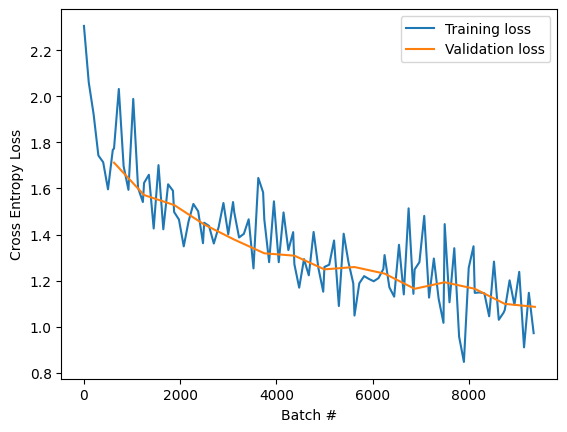

In [ ]:
# Your code here. Don't forget to call model.eval() first!

model.eval()

x_val = np.array(range(0, (len(val_losses))*625, 625)) + 625

plt.plot(new_list, train_losses, label="Training loss")
plt.plot(x_val, val_losses, label="Validation loss")

plt.ylabel('Cross Entropy Loss')
plt.xlabel('Batch #')
plt.legend()

plt.savefig('train_val_loss.png', dpi=600)

2g: Implement code for computing overall accuracy, accuracy per class, and the confusion matrix on the test set.

In [ ]:
# Your code here. Don't forget to call model.eval() first!

model.eval()


preds = []
true_ys = []


for batch, (X, y) in enumerate(test_dataloader):

  if torch.cuda.is_available():
    X = X.to('cuda')
    y = y.to('cuda')

  true_ys += y.tolist()

  pred = model.forward(X).tolist()

  preds += pred

preds = np.argmax(preds, axis=1)
true_ys = np.array(true_ys)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


print(f"Overall accuracy: {accuracy_score(true_ys, preds):.3f}")
print("Confusion Matrix:")
cm = confusion_matrix(true_ys, preds)
print(cm)

for i in range(10):
  acc = cm[i,i] / sum(cm[i, :])
  print(f"Class {i} accuracy: {acc:.3f}")

# Class 4 (deer) has the worst accuracy, and is most often confused for class 2 (bird)

Overall accuracy: 0.618
Confusion Matrix:
[[657  27  89  19   7   6  11   6 130  48]
 [ 41 736  20   6   0   5   7   8  39 138]
 [ 62  13 581  71  59  85  47  37  27  18]
 [ 25  11 131 452  36 195  58  37  29  26]
 [ 29  10 205  78 410  57  70 116  18   7]
 [ 20   5 130 191  23 527  14  57  19  14]
 [  6   8  95 104  44  31 668  12  11  21]
 [ 18   7  58  54  52  90   7 662  10  42]
 [ 74  45  18  12   3   8   5   4 789  42]
 [ 45 133  18  12   5  15  19  15  41 697]]
Class 0 accuracy: 0.657
Class 1 accuracy: 0.736
Class 2 accuracy: 0.581
Class 3 accuracy: 0.452
Class 4 accuracy: 0.410
Class 5 accuracy: 0.527
Class 6 accuracy: 0.668
Class 7 accuracy: 0.662
Class 8 accuracy: 0.789
Class 9 accuracy: 0.697


In [ ]:
a = true_ys == 4
b = preds == 2

idxs = np.where(np.logical_and(a, b))[0][:5]
print(idxs)

[100 223 227 254 295]


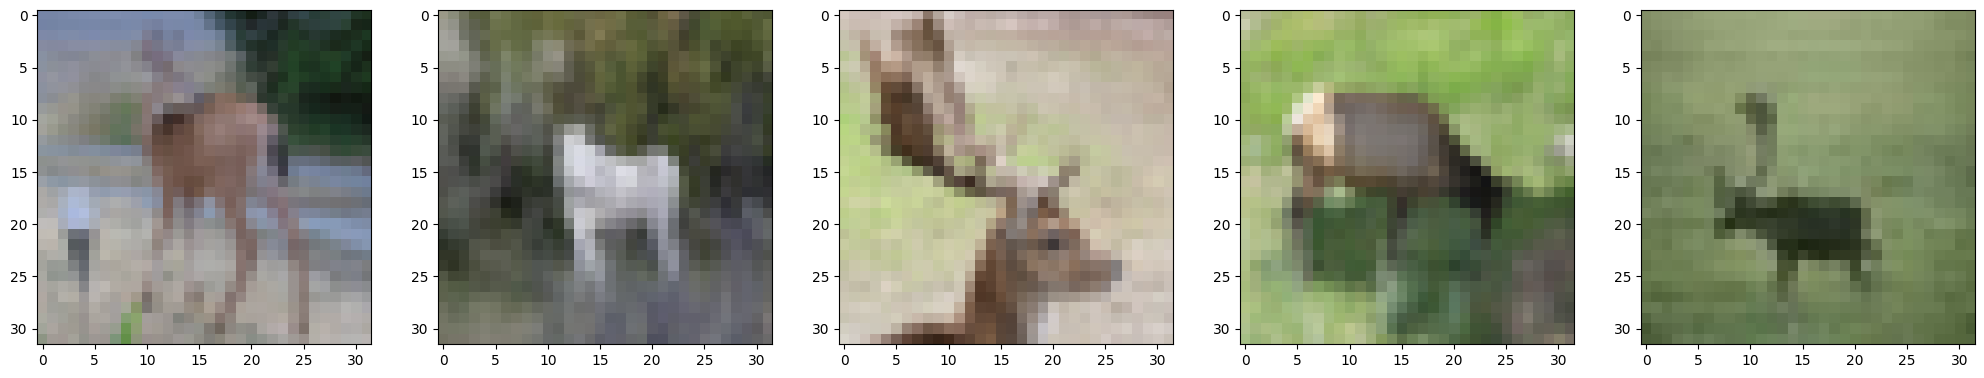

In [ ]:

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i, idx in enumerate(idxs):
  img = test_dataset.__getitem__(idx)[0]

  img = img.permute(1, 2, 0)

  ax[i].imshow(img.numpy())


fig.savefig('deer.png')

Problem 3: Adversarial attacks for trained networks. Write code below

In [ ]:
def fgsm_attack(X, eps, data_grad):

  eta = data_grad.sign()

  new_img = X + eps * eta

  new_img = torch.clamp(new_img, 0, 1)

  return (eta, new_img)

In [ ]:
# Your code here for creating and displaying adversarial images.

eps = 0.007

model = Model()
model.load_state_dict(torch.load('model_14.params'))
model.eval()

model.to('cuda')

loss_fn = nn.CrossEntropyLoss()


# Accuracy counter
correct = 0
adv_examples = []


for batch, (X, y) in enumerate(test_dataloader):

  if torch.cuda.is_available():
    X = X.to('cuda')
    y = y.to('cuda')

  X.requires_grad = True

  m = nn.Softmax()

  pred = model.forward(X)
  init_pred = pred.max(1, keepdim=True)[1]

  if init_pred.item() != y.item():
    continue

  loss = loss_fn(pred, y)

  model.zero_grad()

        # Calculate gradients of model in backward pass
  loss.backward()

        # Collect ``datagrad``
  X_grad = X.grad.data


  eta, perturbed_data = fgsm_attack(X, eps, X_grad)

  output = model.forward(perturbed_data)

        # Check for success
  final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

  adv_conf = m(output).max()


  eta_pred = model.forward(eta)


  eta_conf = m(eta_pred).max()

  eta_pred = eta_pred.max(1, keepdim=True)[1]

  if final_pred.item() == y.item():
    pass
  else:
      # Save some adv examples for visualization later
    if len(adv_examples) < 5:
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      X = X.squeeze().detach().cpu().numpy()
      eta = eta.squeeze().detach().cpu().numpy()
      adv_examples.append((X, init_pred.item(), m(pred).max(), eta, eta_pred.item(), eta_conf, adv_ex, final_pred.item(), adv_conf))

  if len(adv_examples) >= 5:
    break



# img_ = X.permute(1, 2, 0)
# plt.imshow(img_.detach().numpy())
# attack = fgsm_attack(model, img, eps, y)
# plt.imshow(attack)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


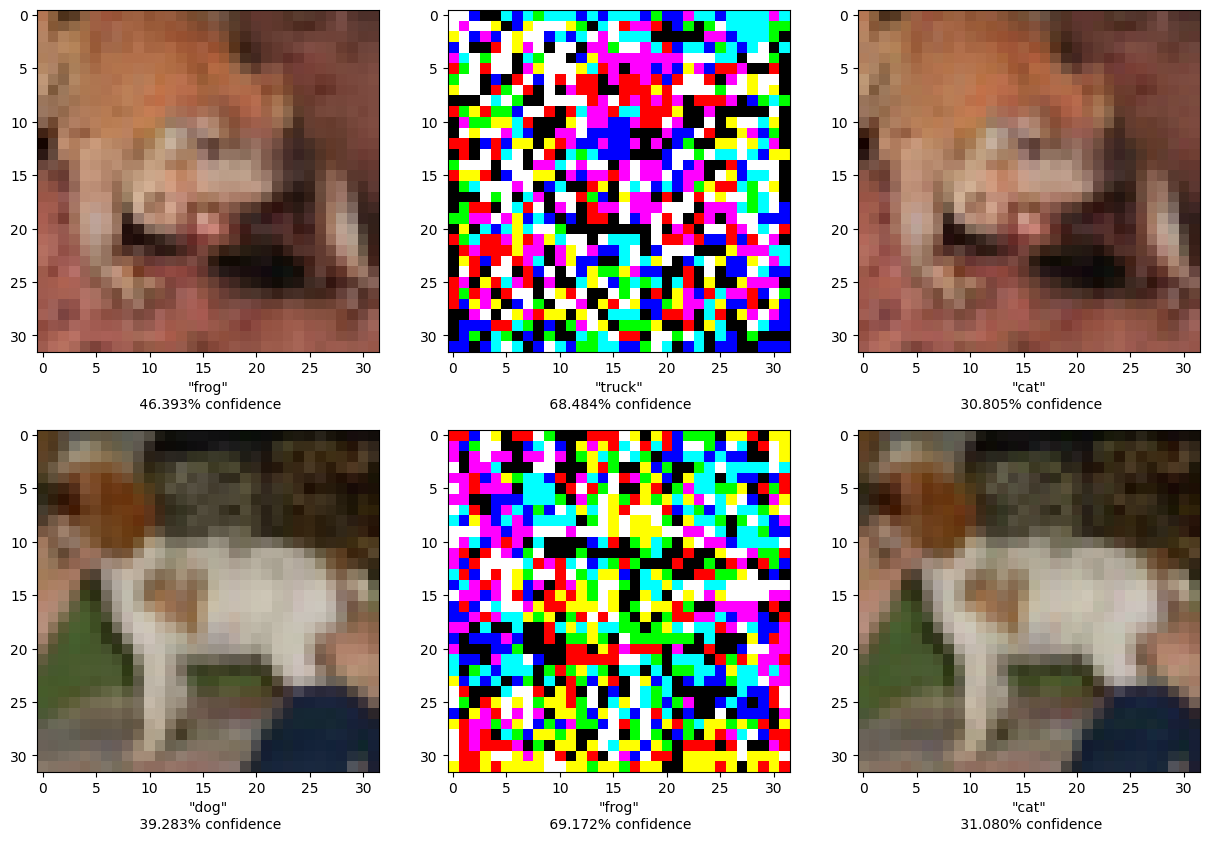

In [ ]:
out = adv_examples[3]

og_img = out[0].swapaxes(0,1).swapaxes(1,2)
og_label = out[1]
og_conf = out[2]


eta_img = out[3].swapaxes(0,1).swapaxes(1,2)
eta_label = out[4]
eta_conf = out[5]

new_img = out[6].swapaxes(0,1).swapaxes(1,2)
new_label = out[7]
adv_conf = out[8]

###############################################################

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(og_img)
axes[0, 1].imshow(eta_img)
axes[0, 2].imshow(new_img)

axes[0, 0].set_xlabel("\"" + label_names[og_label] + "\"" + f"\n {og_conf*100:.3f}% confidence")
axes[0, 1].set_xlabel("\"" + label_names[eta_label] + "\"" + f"\n {eta_conf*100:.3f}% confidence")
axes[0, 2].set_xlabel("\"" + label_names[new_label] + "\"" + f"\n {adv_conf*100:.3f}% confidence")

###############################################################


out = adv_examples[4]

og_img = out[0].swapaxes(0,1).swapaxes(1,2)
og_label = out[1]
og_conf = out[2]

eta_img = out[3].swapaxes(0,1).swapaxes(1,2)
eta_label = out[4]
eta_conf = out[5]

new_img = out[6].swapaxes(0,1).swapaxes(1,2)
new_label = out[7]
adv_conf = out[8]

###############################################################

axes[1,0].imshow(og_img)
axes[1,1].imshow(eta_img)
axes[1,2].imshow(new_img)

axes[1,0].set_xlabel("\"" + label_names[og_label] + "\"" + f"\n {og_conf*100:.3f}% confidence")
axes[1,1].set_xlabel("\"" + label_names[eta_label] + "\"" + f"\n {eta_conf*100:.3f}% confidence")
axes[1,2].set_xlabel("\"" + label_names[new_label] + "\"" + f"\n {adv_conf*100:.3f}% confidence")



plt.savefig('adv_ex.png', dpi=600)